In [134]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Lambda
from keras import layers as KL
from keras.optimizers import RMSprop

from keras import backend as K


In [233]:
import matplotlib.pyplot as plt


In [246]:

def plot_digits(data, title="", show_title=False):
    plt.figure(figsize=(16,2))
    data = data.reshape(-1, 28, 28)
    for i in range(data.shape[0]):
        plt.subplot(1,16, i+1)
        plt.imshow(data[i,:,:], cmap='Reds')
        plt.xticks([])
        plt.yticks([])
    if show_title:
        plt.suptitle(title)
    plt.show()

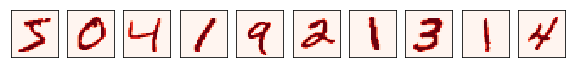

In [248]:
plot_digits(x_train[:10,:])

# Define Layer

In [267]:
# class LRPSequential(Sequential):
#     def __init__(self, **kwargs):
#         super(LRPSequential, self).__init__(**kwargs)
DIVISION_ADJUSTMENT = 0.0001
class LRPDense(Dense):

    def __init__(self, *args, **kwargs):
        self.lrp_rule = kwargs['lrp_rule']
        del kwargs['lrp_rule']
        super(LRPDense, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        super(LRPDense, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        output = super(LRPDense, self).call(x)        
        return output

    def compute_output_shape(self, input_shape):
        return super(LRPDense, self).compute_output_shape(input_shape)
    
    def rel_prop(self, x, relevance):
        return getattr(self, 'rel_prop_%s' % self.lrp_rule)(x, relevance)

    def rel_prop_zplus(self, x_in, relevance):

        def compute(args):
            x, rel = args
            v = K.maximum(0.0, self.kernel)

            z = K.dot(x, v) + DIVISION_ADJUSTMENT
            s = rel / z
            c = K.dot(s, K.transpose(v))
            return c

        return Lambda(compute, output_shape=lambda x: x)([x_in, relevance])

    def rel_prop_beta(self, x_in, relevance, lowest=-1, highest=1):
        def compute(args):
            x, rel = args
            w, v, u = self.kernel, K.maximum(0.0, self.kernel), K.minimum(0.0, self.kernel)
            l, h = x * 0 + lowest, x * 0 + highest

            z = K.dot(x, w) - (K.dot(l, v) + K.dot(h, u)) + DIVISION_ADJUSTMENT
            s = rel / z
            return x * K.dot(s, K.transpose(w))\
                   - (l * K.dot(s, K.transpose(v)) + h * K.dot(s, K.transpose(u)))
        print('sss')
        return Lambda(compute, output_shape=lambda x: x)([x_in, relevance])
    
#     def rel_prop_beta(self, x_in, relevance, lowest=-1, highest=1):
#         def compute(args):
#             x, rel = args
#             w, v, u = self.kernel, K.maximum(0.0, self.kernel), K.minimum(0.0, self.kernel)
#             l, h = x * 0 + lowest, x * 0 + highest

#             z = K.dot(x, w) - (K.dot(l, v) + K.dot(h, u)) + DIVISION_ADJUSTMENT
#             s = rel / z
#             return x * K.dot(s, K.transpose(w))\
#                    - (l * K.dot(s, K.transpose(v)) + h * K.dot(s, K.transpose(u)))
        
#         return Lambda(compute, output_shape=lambda x: x)([x_in, relevance])
    def __repr__(self):
        return '%s-%s' % (type(self).__name__, self.lrp_rule)

In [268]:

batch_size = 128
num_classes = 10
epochs = 5

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(LRPDense(512, lrp_rule='beta', activation='relu', input_shape=(784,)))
# model.add(Dropout(0.2))
model.add(LRPDense(512, lrp_rule='zplus', activation='relu'))
# model.add(Dropout(0.2))
model.add(LRPDense(num_classes, lrp_rule='zplus', activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lrp_dense_78 (LRPDense)      (None, 512)               401920    
_________________________________________________________________
lrp_dense_79 (LRPDense)      (None, 512)               262656    
_________________________________________________________________
lrp_dense_80 (LRPDense)      (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [178]:
a = KL.Input(shape=(32,))
b = Dense(64)(a)
model = Model(inputs=a, outputs=b)

<tf.Tensor 'dense_23/BiasAdd:0' shape=(?, 64) dtype=float32>

In [ ]:


def antirectifier(x):
    x -= K.mean(x, axis=1, keepdims=True)
    x = K.l2_normalize(x, axis=1)
    pos = K.relu(x)
    neg = K.relu(-x)
    return K.concatenate([pos, neg], axis=1)

def antirectifier_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2  # only valid for 2D tensors
    shape[-1] *= 2
    return tuple(shape)

model.add(Lambda(antirectifier,
                 output_shape=antirectifier_output_shape))

In [165]:
model.output

<tf.Tensor 'lrp_dense_53/Softmax:0' shape=(?, 10) dtype=float32>

In [257]:
layers = model.layers
r32 = model.layers[-1].rel_prop_zplus(layers[-2].output, layers[-1].output)
r12 = model.layers[-2].rel_prop_zplus(layers[-3].output, r32)
r01 = model.layers[-3].rel_prop_zplus(model.input, r12)
viz_model = Model(inputs=model.input, outputs=r01)

In [258]:
r01

<tf.Tensor 'lambda_81/MatMul_1:0' shape=(?, 784) dtype=float32>

In [271]:
def lrp_explain(model):
    layers = model.layers
    print(layers)
    outputs = [model.input] + [ l.output for l in layers ]
    relevances = [None]*(len(outputs))
    relevances[-1] = layers[-1].output
    print(outputs)
    print(relevances)
    print(model.layers)
    for i in range(-1, -len(layers)-1, -1):
        print(i)
        
        relevances[i-1] = layers[i].rel_prop(outputs[i-1], relevances[i])
        print(relevances)
#         print()
    print('----')
    return relevances

heatmap = lrp_explain(model)

[LRPDense-beta, LRPDense-zplus, LRPDense-zplus]
[<tf.Tensor 'lrp_dense_78_input:0' shape=(?, 784) dtype=float32>, <tf.Tensor 'lrp_dense_78/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lrp_dense_79/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lrp_dense_80/Softmax:0' shape=(?, 10) dtype=float32>]
[None, None, None, <tf.Tensor 'lrp_dense_80/Softmax:0' shape=(?, 10) dtype=float32>]
[LRPDense-beta, LRPDense-zplus, LRPDense-zplus]
-1
[None, None, <tf.Tensor 'lambda_88/MatMul_1:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lrp_dense_80/Softmax:0' shape=(?, 10) dtype=float32>]
-2
[None, <tf.Tensor 'lambda_89/MatMul_1:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lambda_88/MatMul_1:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lrp_dense_80/Softmax:0' shape=(?, 10) dtype=float32>]
-3
sss
[<tf.Tensor 'lambda_90/sub_1:0' shape=(?, 784) dtype=float32>, <tf.Tensor 'lambda_89/MatMul_1:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lambda_88/MatMul_1:0' shape=(?, 512) dtype=float32>, <tf.Te

In [285]:
# vis = Model(inputs=model.input, outputs=heatmap.ouptu)
viz = Model(inputs=model.input, outputs=heatmap[0])

In [286]:
h = viz.predict(x_train[:5,:])

In [287]:
h.shape

(5, 784)

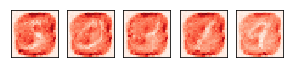

In [288]:
plot_digits(h)

In [281]:

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 83us/step - loss: 0.0230 - acc: 0.9930 - val_loss: 0.1066 - val_acc: 0.9763
Epoch 2/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0184 - acc: 0.9945 - val_loss: 0.0878 - val_acc: 0.9821
Epoch 3/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.0160 - acc: 0.9951 - val_loss: 0.1105 - val_acc: 0.9799
Epoch 4/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0127 - acc: 0.9960 - val_loss: 0.1098 - val_acc: 0.9804
Epoch 5/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.0115 - acc: 0.9965 - val_loss: 0.1106 - val_acc: 0.9814
Test loss: 0.110590703013
Test accuracy: 0.9814


In [99]:
viz_model = Model(inputs=model.input, outputs=heatmap)

TypeError: Output tensors to a Model must be Keras tensors. Found: Tensor("sub_1:0", shape=(?, 784), dtype=float32)

In [98]:
viz_model.predict(x_train[:5,:])

array([[ 0.11384565,  0.09688398,  0.08379211,  0.11497436,  0.09848945,
         0.08834918,  0.14573166,  0.05893434,  0.10097259,  0.09802666],
       [ 0.10312912,  0.09936639,  0.08958689,  0.10862304,  0.09725285,
         0.10144849,  0.0846601 ,  0.05637852,  0.12093848,  0.1386161 ],
       [ 0.09255937,  0.10434079,  0.06701206,  0.14013456,  0.09003647,
         0.08171756,  0.11649356,  0.05378961,  0.11928923,  0.13462685],
       [ 0.12125329,  0.12312869,  0.07909529,  0.11854502,  0.07500505,
         0.09595336,  0.10659783,  0.07797137,  0.0812717 ,  0.12117846],
       [ 0.11129158,  0.0960509 ,  0.0758284 ,  0.11121193,  0.08253022,
         0.08595848,  0.1358384 ,  0.07327467,  0.11887516,  0.10914025]], dtype=float32)

In [94]:
model.output

<tf.Tensor 'lrp_dense_26/Softmax:0' shape=(?, 10) dtype=float32>

In [96]:
heatmap

<tf.Tensor 'sub_1:0' shape=(?, 784) dtype=float32>

In [101]:
model.output._keras_history

(LRPDense-zplus, 0, 0)

In [102]:
heatmap._keras_history

AttributeError: 'Tensor' object has no attribute '_keras_history'

In [104]:
K.eval(heatmap, feed_dict={ model.input : x_train[:5, :]})

TypeError: eval() got an unexpected keyword argument 'feed_dict'